In [2]:
import pandas as pd
from scipy.stats import levene
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from keras.layers import Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
#from imblearn.over_sampling import SMOTE

In [3]:
DADOS_ENEM_2023 = pd.read_csv('C:/Users/helio/OneDrive/Documents/UNB/ARTIGOS_UNB/ENEM_2023/microdados_enem_2023/DADOS/MICRODADOS_ENEM_2023.csv', sep=";", encoding='ISO-8859-1')

In [4]:
PARTIC_ENEM_2023_DF = DADOS_ENEM_2023[
    (DADOS_ENEM_2023["TP_PRESENCA_CN"] == 1) & 
    (DADOS_ENEM_2023["TP_PRESENCA_CH"] == 1) & 
    (DADOS_ENEM_2023["TP_PRESENCA_LC"] == 1) & 
    (DADOS_ENEM_2023["TP_PRESENCA_MT"] == 1) & 
    (DADOS_ENEM_2023["SG_UF_ESC"] == "GO") &
    (DADOS_ENEM_2023["NU_NOTA_CN"] > 1) & 
    (DADOS_ENEM_2023["NU_NOTA_CH"] > 1) & 
    (DADOS_ENEM_2023["NU_NOTA_MT"] > 1) & 
    (DADOS_ENEM_2023["NU_NOTA_LC"] > 1) &
    (DADOS_ENEM_2023["TP_ENSINO"] == 1) 
]

In [5]:
REG_ENEM_2023_DF = PARTIC_ENEM_2023_DF[[ 'TP_SEXO', 'TP_ESCOLA', 'TP_NACIONALIDADE', 'TP_COR_RACA', 'TP_ESTADO_CIVIL',
                                        'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA','TP_LOCALIZACAO_ESC', 'CO_MUNICIPIO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 
                                        'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001','Q002','Q003','Q004','Q005','Q006','Q007', 'Q008','Q009',
                                        'Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025']]

categorical_columns = ['TP_SEXO', 'TP_ESCOLA', 'TP_NACIONALIDADE', 'TP_COR_RACA', 'TP_ESTADO_CIVIL', 'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA', 
                       'TP_LOCALIZACAO_ESC', 'CO_MUNICIPIO_ESC', 'Q001','Q002','Q003','Q004', 'Q006','Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019', 'Q020','Q021','Q022','Q023','Q024','Q025']

# No âmbito do DF, as variáveis 'TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO' apresentaram como valores as contanstes 0 e 2. Assim, não participarão do modelo.

In [6]:
# Teste de Levene e ANOVA
# Calcular média das notas e status
REG_ENEM_2023_DF['MEDIA_RESULTADO'] = (
    (REG_ENEM_2023_DF['NU_NOTA_CN'] + 
     REG_ENEM_2023_DF['NU_NOTA_CH'] + 
     REG_ENEM_2023_DF['NU_NOTA_LC'] + 
     REG_ENEM_2023_DF['NU_NOTA_MT'] + 
     REG_ENEM_2023_DF['NU_NOTA_REDACAO']) / 5
)

C:\Users\helio\AppData\Local\Temp\ipykernel_9448\2196312138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REG_ENEM_2023_DF['MEDIA_RESULTADO'] = (


In [7]:
import pandas as pd
import pingouin as pg

AMOSTRA_ENEM_DF = REG_ENEM_2023_DF.sample(n = 100)

# Dividindo a amostra com estratificação
#AMOSTRA_ENEM_DF, _ = train_test_split(PARTIC_ENEM_2023_DF, test_size=0.005, stratify=PARTIC_ENEM_2023_DF[['TP_SEXO']])
levene_SX = pg.homoscedasticity(AMOSTRA_ENEM_DF, dv="MEDIA_RESULTADO", group="TP_SEXO", method='levene', alpha=0.05)
levene_ESC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_ESCOLA", method='levene', alpha=0.05)
levene_TP_NAC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_NACIONALIDADE", method='levene', alpha=0.05)
levene_TP_COR = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_COR_RACA", method='levene', alpha=0.05)
levene_TP_ESTCIV = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_ESTADO_CIVIL", method='levene', alpha=0.05)
levene_TP_DEP_ADM = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_DEPENDENCIA_ADM_ESC", method='levene', alpha=0.05)
levene_FX_ETAR = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_FAIXA_ETARIA", method='levene', alpha=0.05)
levene_LOC_ESC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_LOCALIZACAO_ESC", method='levene', alpha=0.05)
levene_MUN_ESC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="CO_MUNICIPIO_ESC", method='levene', alpha=0.05)
levene_Q001 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q001", method='levene', alpha=0.05)
levene_Q002 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q002", method='levene', alpha=0.05)
levene_Q003 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q003", method='levene', alpha=0.05)
levene_Q004 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q004", method='levene', alpha=0.05)
levene_Q005 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q005", method='levene', alpha=0.05)
levene_Q006 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q006", method='levene', alpha=0.05)
levene_Q007 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q007", method='levene', alpha=0.05)
levene_Q008 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q008", method='levene', alpha=0.05)
levene_Q009 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q009", method='levene', alpha=0.05)
levene_Q010 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q010", method='levene', alpha=0.05)
levene_Q011 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q011", method='levene', alpha=0.05)
levene_Q012 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q012", method='levene', alpha=0.05)
levene_Q013 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q013", method='levene', alpha=0.05)
levene_Q014 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q014", method='levene', alpha=0.05)
levene_Q015 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q015", method='levene', alpha=0.05)
levene_Q016 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q016", method='levene', alpha=0.05)
levene_Q017 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q017", method='levene', alpha=0.05)
levene_Q018 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q018", method='levene', alpha=0.05)
levene_Q019 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q019", method='levene', alpha=0.05)
levene_Q020 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q020", method='levene', alpha=0.05)
levene_Q021 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q021", method='levene', alpha=0.05)
levene_Q022 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q022", method='levene', alpha=0.05)
levene_Q023 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q023", method='levene', alpha=0.05)
levene_Q024 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q024", method='levene', alpha=0.05)
levene_Q025 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q025", method='levene', alpha=0.05)

In [8]:
# Criar lista de resultados
resultados = [
    ('TP_SEXO', levene_SX['W'].values[0], levene_SX['pval'].values[0]),
    ('TP_ESCOLA', levene_ESC['W'].values[0], levene_ESC['pval'].values[0]),
    ('TP_NACIONALIDADE', levene_TP_NAC['W'].values[0], levene_TP_NAC['pval'].values[0]),
    ('TP_COR_RACA', levene_TP_COR['W'].values[0], levene_TP_COR['pval'].values[0]),
    ('TP_ESTADO_CIVIL', levene_TP_ESTCIV['W'].values[0], levene_TP_ESTCIV['pval'].values[0]),
    ('TP_DEPENDENCIA_ADM_ESC', levene_TP_DEP_ADM['W'].values[0], levene_TP_DEP_ADM['pval'].values[0]),
    ('TP_FAIXA_ETARIA', levene_FX_ETAR['W'].values[0], levene_FX_ETAR['pval'].values[0]),
    ('TP_LOCALIZACAO_ESC', levene_LOC_ESC['W'].values[0], levene_LOC_ESC['pval'].values[0]),
    ('CO_MUNICIPIO_ESC', levene_MUN_ESC['W'].values[0], levene_MUN_ESC['pval'].values[0]),
    ('Q001', levene_Q001['W'].values[0], levene_Q001['pval'].values[0]),
    ('Q002', levene_Q002['W'].values[0], levene_Q002['pval'].values[0]),
    ('Q003', levene_Q003['W'].values[0], levene_Q003['pval'].values[0]),
    ('Q004', levene_Q004['W'].values[0], levene_Q004['pval'].values[0]),
    ('Q005', levene_Q005['W'].values[0], levene_Q005['pval'].values[0]),
    ('Q006', levene_Q006['W'].values[0], levene_Q006['pval'].values[0]),
    ('Q007', levene_Q007['W'].values[0], levene_Q007['pval'].values[0]),
    ('Q008', levene_Q008['W'].values[0], levene_Q008['pval'].values[0]),
    ('Q009', levene_Q009['W'].values[0], levene_Q009['pval'].values[0]),
    ('Q010', levene_Q010['W'].values[0], levene_Q010['pval'].values[0]),
    ('Q011', levene_Q011['W'].values[0], levene_Q011['pval'].values[0]),
    ('Q012', levene_Q012['W'].values[0], levene_Q012['pval'].values[0]),
    ('Q013', levene_Q013['W'].values[0], levene_Q013['pval'].values[0]),
    ('Q014', levene_Q014['W'].values[0], levene_Q014['pval'].values[0]),
    ('Q015', levene_Q015['W'].values[0], levene_Q015['pval'].values[0]),
    ('Q016', levene_Q016['W'].values[0], levene_Q016['pval'].values[0]),
    ('Q017', levene_Q017['W'].values[0], levene_Q017['pval'].values[0]),
    ('Q018', levene_Q018['W'].values[0], levene_Q018['pval'].values[0]),
    ('Q019', levene_Q019['W'].values[0], levene_Q019['pval'].values[0]),
    ('Q020', levene_Q020['W'].values[0], levene_Q020['pval'].values[0]),
    ('Q021', levene_Q021['W'].values[0], levene_Q021['pval'].values[0]),
    ('Q022', levene_Q022['W'].values[0], levene_Q022['pval'].values[0]),
    ('Q023', levene_Q023['W'].values[0], levene_Q023['pval'].values[0]),
    ('Q024', levene_Q024['W'].values[0], levene_Q024['pval'].values[0]),
    ('Q025', levene_Q025['W'].values[0], levene_Q025['pval'].values[0])
]

# Criar DataFrame
df_resultados_lev = pd.DataFrame(resultados, columns=['Grupo', 'W', 'p-valor'])
df_resultados_lev['p-value'] = np.round(df_resultados_lev['p-valor'], 2)
df_resultados_lev['Teste'] = np.where(df_resultados_lev['p-value'] > 0.05, "ANOVA", "ANOVA_WELCH")
df_resultados_lev.head(60)

,Grupo,W,p-valor,p-value,Teste
0,TP_SEXO,0.007280,9.321778e-01,0.93,ANOVA
1,TP_ESCOLA,47.382700,5.966771e-12,0.00,ANOVA_WELCH
2,TP_NACIONALIDADE,11.667701,1.818868e-09,0.00,ANOVA_WELCH
3,TP_COR_RACA,14.530050,3.006779e-14,0.00,ANOVA_WELCH
4,TP_ESTADO_CIVIL,3.441087,8.096963e-03,0.01,ANOVA_WELCH
5,TP_DEPENDENCIA_ADM_ESC,19.257498,1.810899e-12,0.00,ANOVA_WELCH
6,TP_FAIXA_ETARIA,2.430873,1.133292e-03,0.00,ANOVA_WELCH
7,TP_LOCALIZACAO_ESC,0.546650,4.596962e-01,0.46,ANOVA
8,CO_MUNICIPIO_ESC,2.954588,1.029181e-47,0.00,ANOVA_WELCH
9,Q001,4.337079,8.206012e-05,0.00,ANOVA_WELCH


In [9]:
#AMOSTRA_ENEM_DF = REG_ENEM_2023_DF
WA_SX = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_SEXO', data=AMOSTRA_ENEM_DF)
WA_ESC = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_ESCOLA', data=AMOSTRA_ENEM_DF)
WA_TP_NAC = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_NACIONALIDADE', data=AMOSTRA_ENEM_DF)
WA_TP_COR = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_COR_RACA', data=AMOSTRA_ENEM_DF)
WA_TP_ESTCIV = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_ESTADO_CIVIL', data=AMOSTRA_ENEM_DF)
WA_TP_DEP_ADM = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_DEPENDENCIA_ADM_ESC', data=AMOSTRA_ENEM_DF)
WA_FX_ETAR = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_FAIXA_ETARIA', data=AMOSTRA_ENEM_DF)
WA_LOC_ESC = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_LOCALIZACAO_ESC', data=AMOSTRA_ENEM_DF)
WA_MUN_ESC = pg.welch_anova(dv="MEDIA_RESULTADO", between='CO_MUNICIPIO_ESC', data=AMOSTRA_ENEM_DF)
WA_Q001 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q001', data=AMOSTRA_ENEM_DF)
WA_Q002 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q002', data=AMOSTRA_ENEM_DF)
WA_Q003 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q003', data=AMOSTRA_ENEM_DF)
WA_Q004 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q004', data=AMOSTRA_ENEM_DF)
WA_Q005 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q005', data=AMOSTRA_ENEM_DF)
WA_Q006 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q006', data=AMOSTRA_ENEM_DF)
WA_Q007 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q007', data=AMOSTRA_ENEM_DF)
WA_Q008 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q008', data=AMOSTRA_ENEM_DF)
WA_Q009 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q009', data=AMOSTRA_ENEM_DF)
WA_Q010 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q010', data=AMOSTRA_ENEM_DF)
WA_Q011 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q011', data=AMOSTRA_ENEM_DF)
WA_Q012 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q012', data=AMOSTRA_ENEM_DF)
WA_Q013 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q013', data=AMOSTRA_ENEM_DF)
WA_Q014 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q014', data=AMOSTRA_ENEM_DF)
WA_Q015 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q015', data=AMOSTRA_ENEM_DF)
WA_Q016 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q016', data=AMOSTRA_ENEM_DF)
WA_Q017 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q017', data=AMOSTRA_ENEM_DF)
WA_Q018 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q018', data=AMOSTRA_ENEM_DF)
WA_Q019 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q019', data=AMOSTRA_ENEM_DF)
WA_Q020 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q020', data=AMOSTRA_ENEM_DF)
WA_Q021 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q021', data=AMOSTRA_ENEM_DF)
WA_Q022 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q022', data=AMOSTRA_ENEM_DF)
WA_Q023 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q023', data=AMOSTRA_ENEM_DF)
WA_Q024 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q024', data=AMOSTRA_ENEM_DF)
WA_Q025 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q025', data=AMOSTRA_ENEM_DF)

C:\ProgramData\anaconda3\Lib\site-packages\pingouin\parametric.py:1360: RuntimeWarning: divide by zero encountered in scalar divide
  ddof2 = 1 / lamb
C:\ProgramData\anaconda3\Lib\site-packages\pingouin\parametric.py:1354: RuntimeWarning: invalid value encountered in scalar divide
  ms_betadj = ss_betadj / ddof1
C:\ProgramData\anaconda3\Lib\site-packages\pingouin\parametric.py:1357: RuntimeWarning: invalid value encountered in scalar divide
  lamb = (3 * np.sum((1 / (grp.count() - 1)) * (1 - (weights / weights.sum())) ** 2)) / (


In [10]:
# Criar lista de resultados
resultados = [
    ('TP_SEXO', WA_SX['F'].values[0], WA_SX['p-unc'].values[0]),
    ('TP_ESCOLA', WA_ESC['F'].values[0], WA_ESC['p-unc'].values[0]),
    ('TP_NACIONALIDADE', WA_TP_NAC['F'].values[0], WA_TP_NAC['p-unc'].values[0]),
    ('TP_COR_RACA', WA_TP_COR['F'].values[0], WA_TP_COR['p-unc'].values[0]),
    ('TP_ESTADO_CIVIL', WA_TP_ESTCIV['F'].values[0], WA_TP_ESTCIV['p-unc'].values[0]),
    ('TP_DEPENDENCIA_ADM_ESC', WA_TP_DEP_ADM['F'].values[0], WA_TP_DEP_ADM['p-unc'].values[0]),
    ('TP_FAIXA_ETARIA', WA_FX_ETAR['F'].values[0], WA_FX_ETAR['p-unc'].values[0]),
    ('TP_LOCALIZACAO_ESC', WA_LOC_ESC['F'].values[0], WA_LOC_ESC['p-unc'].values[0]),
    ('CO_MUNICIPIO_ESC', WA_MUN_ESC['F'].values[0], WA_MUN_ESC['p-unc'].values[0]),
    ('Q001', WA_Q001['F'].values[0], WA_Q001['p-unc'].values[0]),
    ('Q002', WA_Q002['F'].values[0], WA_Q002['p-unc'].values[0]),
    ('Q003', WA_Q003['F'].values[0], WA_Q003['p-unc'].values[0]),
    ('Q004', WA_Q004['F'].values[0], WA_Q004['p-unc'].values[0]),
    ('Q005', WA_Q005['F'].values[0], WA_Q005['p-unc'].values[0]),
    ('Q006', WA_Q006['F'].values[0], WA_Q006['p-unc'].values[0]),
    ('Q007', WA_Q007['F'].values[0], WA_Q007['p-unc'].values[0]),
    ('Q008', WA_Q008['F'].values[0], WA_Q008['p-unc'].values[0]),
    ('Q009', WA_Q009['F'].values[0], WA_Q009['p-unc'].values[0]),
    ('Q010', WA_Q010['F'].values[0], WA_Q010['p-unc'].values[0]),
    ('Q011', WA_Q011['F'].values[0], WA_Q011['p-unc'].values[0]),
    ('Q012', WA_Q012['F'].values[0], WA_Q012['p-unc'].values[0]),
    ('Q013', WA_Q013['F'].values[0], WA_Q013['p-unc'].values[0]),
    ('Q014', WA_Q014['F'].values[0], WA_Q014['p-unc'].values[0]),
    ('Q015', WA_Q015['F'].values[0], WA_Q015['p-unc'].values[0]),
    ('Q016', WA_Q016['F'].values[0], WA_Q016['p-unc'].values[0]),
    ('Q017', WA_Q017['F'].values[0], WA_Q017['p-unc'].values[0]),
    ('Q018', WA_Q018['F'].values[0], WA_Q018['p-unc'].values[0]),
    ('Q019', WA_Q019['F'].values[0], WA_Q019['p-unc'].values[0]),
    ('Q020', WA_Q020['F'].values[0], WA_Q020['p-unc'].values[0]),
    ('Q021', WA_Q021['F'].values[0], WA_Q021['p-unc'].values[0]),
    ('Q022', WA_Q022['F'].values[0], WA_Q022['p-unc'].values[0]),
    ('Q023', WA_Q023['F'].values[0], WA_Q023['p-unc'].values[0]),
    ('Q024', WA_Q024['F'].values[0], WA_Q024['p-unc'].values[0]),
    ('Q025', WA_Q025['F'].values[0], WA_Q025['p-unc'].values[0])
]

# Criar DataFrame
df_resultados_WA = pd.DataFrame(resultados, columns=['Grupo', 'F', 'p-unc'])
df_resultados_WA['Pvalor'] = np.round(df_resultados_WA['p-unc'],2)
df_resultados_WA['AVALIACAO'] = np.where(df_resultados_WA['Pvalor'] > 0.1, "Médias iguais entre os grupos", "Médias diferentes")

grupos_diferentes = df_resultados_WA[df_resultados_WA['AVALIACAO'] == 'Médias diferentes']['Grupo']
grupos_iguais = df_resultados_WA[df_resultados_WA['AVALIACAO'] == 'Médias iguais entre os grupos']['Grupo']
categorical_columns = grupos_diferentes
drop_columns = grupos_iguais
df_resultados_WA

,Grupo,F,p-unc,Pvalor,AVALIACAO
0,TP_SEXO,0.498089,4.824184e-01,0.48,Médias iguais entre os grupos
1,TP_ESCOLA,49.438205,4.536994e-09,0.00,Médias diferentes
2,TP_NACIONALIDADE,0.000000,1.000000e+00,1.00,Médias iguais entre os grupos
3,TP_COR_RACA,3.611411,7.997493e-02,0.08,Médias diferentes
4,TP_ESTADO_CIVIL,0.431215,5.779195e-01,0.58,Médias iguais entre os grupos
5,TP_DEPENDENCIA_ADM_ESC,22.140941,1.900234e-04,0.00,Médias diferentes
6,TP_FAIXA_ETARIA,0.214353,9.203122e-01,0.92,Médias iguais entre os grupos
7,TP_LOCALIZACAO_ESC,NaN,NaN,NaN,Médias diferentes
8,CO_MUNICIPIO_ESC,0.673531,9.293059e-01,0.93,Médias iguais entre os grupos
9,Q001,3.171351,1.329067e-02,0.01,Médias diferentes


In [11]:
print(grupos_iguais)
#REG_ENEM_2023_DF

grupos_iguais = df_resultados_WA[df_resultados_WA['AVALIACAO'] == 'Médias iguais entre os grupos']['Grupo']
categorical_columns = grupos_diferentes.tolist()
drop_columns = grupos_iguais.tolist()
REG_ENEM_2023_DF = REG_ENEM_2023_DF.drop(columns=drop_columns)
#REG_ENEM_2023_DF
#REG_ENEM_2023_DF[categorical_columns]
#REG_ENEM_2023_DF.columns

0              TP_SEXO
2     TP_NACIONALIDADE
4      TP_ESTADO_CIVIL
6      TP_FAIXA_ETARIA
8     CO_MUNICIPIO_ESC
10                Q002
12                Q004
15                Q007
19                Q011
20                Q012
21                Q013
23                Q015
24                Q016
27                Q019
30                Q022
31                Q023
33                Q025
Name: Grupo, dtype: object


In [12]:
REG_ENEM_2023_DF = pd.get_dummies(REG_ENEM_2023_DF, columns=categorical_columns, prefix=categorical_columns)
# Definir X e y
X_df = REG_ENEM_2023_DF.drop(columns=['MEDIA_RESULTADO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])
y_df = REG_ENEM_2023_DF['MEDIA_RESULTADO']

# Resamplear usando SMOTE
#smt = SMOTE()
#X_df, y_df = smt.fit_resample(X_df, y_df)

print(REG_ENEM_2023_DF.shape)
print(X_df.shape)

(27109, 104)
(27109, 98)


In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
RANDON_SEED = 42

# Criando o nosso seletor

variaveis = int(REG_ENEM_2023_DF.shape[1]*1)

selector = SelectKBest(score_func=mutual_info_regression, k = variaveis)

selector.fit_transform(X_df,y_df)
cols = selector.get_support(indices = True)
selected_columns = X_df.iloc[:,cols].columns.tolist()
X_df = X_df[selected_columns]

scores = selector.scores_
cols = selector.get_support(indices = True)
selected_columns = X_df.iloc[:,cols].columns.tolist()

#df_scores = pd.DataFrame(scores, columns=['score_k_best'])
#df_scores.reset_index(drop=True, inplace=True)

scores_df = pd.DataFrame({'Variáveis': X_df.columns, 'Scores': scores})
scores_df['REL'] = scores_df['Scores']/np.sum(scores_df['Scores'])
scores_df.sort_values(by='Scores', ascending=False).head(65)
#df_scores.plot()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=104 is greater than n_features=98. All the features will be returned.
  warnings.warn(


,Variáveis,Scores,REL
9,TP_DEPENDENCIA_ADM_ESC_2.0,0.138896,0.092377
11,TP_DEPENDENCIA_ADM_ESC_4.0,0.131622,0.087540
0,TP_ESCOLA_2,0.128595,0.085526
1,TP_ESCOLA_3,0.128540,0.085489
93,Q024_A,0.057453,0.038211
...,...,...,...
94,Q024_B,0.003612,0.002402
12,TP_LOCALIZACAO_ESC_1.0,0.003389,0.002254
14,Q001_A,0.003345,0.002225
31,Q005_4,0.003229,0.002148


In [14]:
# Fazendo o fit com os dados
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.20, random_state = 42)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

modelo_2 = Sequential()
modelo_2.add(Dense(variaveis, input_dim = X_train.shape[1], activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-6),
          bias_regularizer=regularizers.L2(1e-6), activity_regularizer=regularizers.L2(1e-6), 
                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDON_SEED)))
modelo_2.add(Dropout(0.1))
modelo_2.add(Dense(int(variaveis*1.2), activation = 'relu'))
modelo_2.add(Dropout(0.2))
modelo_2.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

modelo_2.compile(loss='mse',optimizer=opt, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

resultado_modelo_2 = modelo_2.fit(X_train_scaled, y_train, epochs=700, batch_size = 32, validation_split=0.15, callbacks=[early_stopping])

modelo_2.evaluate(X_test_scaled, y_test)

predictions_teste = modelo_2.predict(X_test_scaled)
#previsao = pd.DataFrame(predictions_teste)
#rev_trans_test = sc.inverse_transform(X_test_scaled)
#rev_trans_test = pd.DataFrame(rev_trans_test)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 302954.2188 - mae: 541.7947 - val_loss: 247166.9375 - val_mae: 488.8933
Epoch 2/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 207789.2812 - mae: 443.8878 - val_loss: 77447.5703 - val_mae: 254.9669
Epoch 3/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 56028.5898 - mae: 206.5289 - val_loss: 20910.7188 - val_mae: 115.8404
Epoch 4/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 20263.2793 - mae: 113.6806 - val_loss: 15038.2832 - val_mae: 96.2186
Epoch 5/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16774.5215 - mae: 102.1065 - val_loss: 12865.2070 - val_mae: 89.0647
Epoch 6/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14477.9941 - mae: 94.6162 - val_loss: 11238.4521 - val_mae: 83.3481
Epoch 7/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13036.5840 - mae: 90.0022 - val_loss: 10045.3545 - val_mae: 78.9632
Epoch 8/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11742.9365 - mae: 85.6936

In [15]:
acuracia_modelo_2 = modelo_2.evaluate(X_test_scaled, y_test, verbose=2)
print("Testes Scores modelo_2,",acuracia_modelo_2[0])
print("Testes Accuracy modelo_2,",acuracia_modelo_2[1])

170/170 - 0s - 796us/step - loss: 6326.8003 - mae: 63.8103
Testes Scores modelo_2, 6326.80029296875
Testes Accuracy modelo_2, 63.8103141784668


array([[<Axes: title={'center': 'y_previsto'}>]], dtype=object)

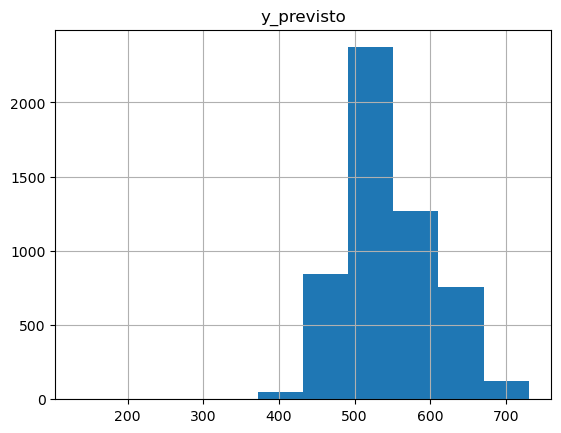

In [16]:
predictions_teste = pd.DataFrame(predictions_teste.flatten(), columns=['y_previsto'])
predictions_teste.hist()
#y_test.hist()

In [17]:
print("A média Máxima da media projetada é de: ", predictions_teste.max())
print("A média Mínima da media projetada é de: ", predictions_teste.min())
print("A média da média da media projetada é de: ", predictions_teste.mean())
print("A médiana da media projetada é de: ", predictions_teste.median())
print("A média Máxima do y_test real é de: ", y_test.max())
print("A média Mínima do y_test real é de: ", y_test.min())
print("A média da média do y_test real é de: ", y_test.mean())
print("A médiana da média do y_test real é de: ", y_test.median())

A média Máxima da media projetada é de:  y_previsto    730.364136
dtype: float32
A média Mínima da media projetada é de:  y_previsto    133.895325
dtype: float32
A média da média da media projetada é de:  y_previsto    545.673828
dtype: float32
A médiana da media projetada é de:  y_previsto    533.714233
dtype: float32
A média Máxima do y_test real é de:  813.9199999999998
A média Mínima do y_test real é de:  274.48
A média da média do y_test real é de:  551.4578126152711
A médiana da média do y_test real é de:  550.89


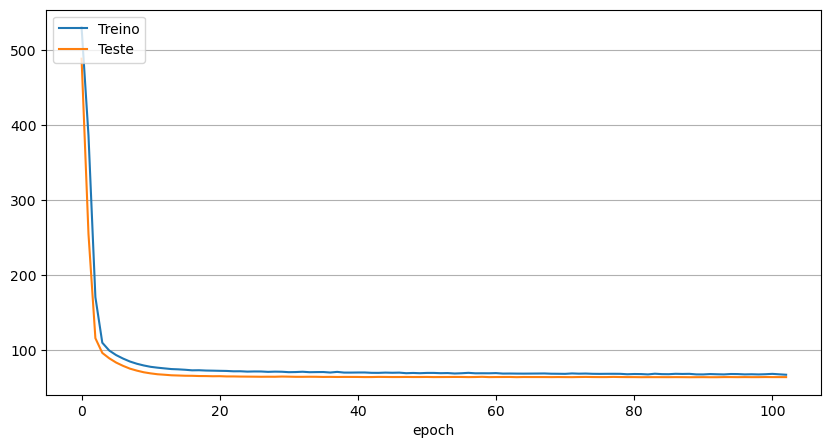

In [18]:
plt.subplots(figsize=(10,5))
plt.plot(resultado_modelo_2.history['mae'])
plt.plot(resultado_modelo_2.history['val_mae'])
plt.xlabel('epoch')
plt.grid(axis='y')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

In [19]:
#df_y_test = pd.DataFrame(y_test)
#previsao_modelo_2 = pd.DataFrame({'y_previsto': predictions_teste['y_previsto'], 'MEDIA_RESULTADO': df_y_test['MEDIA_RESULTADO']})

df_y_test = pd.DataFrame(y_test, columns=['MEDIA_RESULTADO'])
df_y_test.reset_index(drop=True, inplace=True)

df_predictions_teste = pd.DataFrame(predictions_teste, columns=['y_previsto'])

previsao_modelo_2 = pd.concat([predictions_teste, df_y_test],join='outer', axis=1)

previsao_modelo_2.reset_index(drop=True, inplace=True)

previsao_modelo_2['ERRO'] = np.abs(previsao_modelo_2['y_previsto'] - previsao_modelo_2['MEDIA_RESULTADO'])
previsao_modelo_2['ERRO_REL'] = np.abs(previsao_modelo_2['ERRO'] / previsao_modelo_2['MEDIA_RESULTADO'])
previsao_modelo_2.sort_values(by='ERRO_REL', ascending=True).head(15)

,y_previsto,MEDIA_RESULTADO,ERRO,ERRO_REL
4254,527.364990,527.36,0.004990,0.000009
4668,552.315186,552.30,0.015186,0.000027
1928,607.943115,607.96,0.016885,0.000028
3155,621.814331,621.86,0.045669,0.000073
2605,559.413696,559.46,0.046304,0.000083
5054,505.815948,505.86,0.044052,0.000087
3712,563.706482,563.64,0.066482,0.000118
945,651.878967,651.76,0.118967,0.000183
2269,543.536133,543.64,0.103867,0.000191
846,601.552551,601.70,0.147449,0.000245


In [20]:
MAE_MODELO_2 = sum(previsao_modelo_2['ERRO'])/len(previsao_modelo_2['ERRO'])
MAPE_MODELO_2 = np.mean(previsao_modelo_2['ERRO_REL'])

print(MAE_MODELO_2)
print(MAPE_MODELO_2)

63.81029926757339
0.12330384507738625


In [ ]:
# Definir os intervalos de erro
bins = [0, 0.1, 0.3, 0.5, 0.7, float('inf')]
labels = ['Erro entre 0% e 10%', 'Erro entre 10% e 30%', 'Erro entre 30% e 50%', 'Erro entre 50% e 70%', 'Acima de 70%']

# Categorizar os dados
previsao_modelo_2['Intervalo_ERRO_REL'] = pd.cut(previsao_modelo_2['ERRO_REL'], bins=bins, labels=labels)

# Construir a tabela de distribuição de frequência
frequencia = previsao_modelo_2['Intervalo_ERRO_REL'].value_counts().sort_index()

# Exibir a tabela de distribuição de frequência
tabela_frequencia = pd.DataFrame({'Intervalo de Erro Relativo': labels, 'Frequência': frequencia})
tabela_frequencia['FREQ_REL'] = tabela_frequencia['Frequência']/sum(tabela_frequencia['Frequência'])
tabela_frequencia

In [39]:
# Definir os intervalos de erro
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['Erro entre 0 e 50 pontos', 'Erro entre 50 e 100 pontos', 'Erro entre 100 e 150 pontos', 'Erro entre 150 e 200 pontos', 'Acima de 200 pontos']

# Categorizar os dados
previsao_modelo_2['Intervalo_ERRO'] = pd.cut(previsao_modelo_2['ERRO'], bins=bins, labels=labels)

# Construir a tabela de distribuição de frequência
frequencia_abs = previsao_modelo_2['Intervalo_ERRO'].value_counts().sort_index()

# Exibir a tabela de distribuição de frequência
tabela_frequencia_abs = pd.DataFrame({'Intervalo de Erro': labels, 'Frequência': frequencia_abs})
tabela_frequencia['FREQ_ABS'] = tabela_frequencia_abs['Frequência']/sum(tabela_frequencia['Frequência'])
tabela_frequencia_abs

,Intervalo de Erro,Frequência
Intervalo_ERRO,,
Erro entre 0 e 50 pontos,Erro entre 0 e 50 pontos,2512
Erro entre 50 e 100 pontos,Erro entre 50 e 100 pontos,1786
Erro entre 100 e 150 pontos,Erro entre 100 e 150 pontos,812
Erro entre 150 e 200 pontos,Erro entre 150 e 200 pontos,247
Acima de 200 pontos,Acima de 200 pontos,65


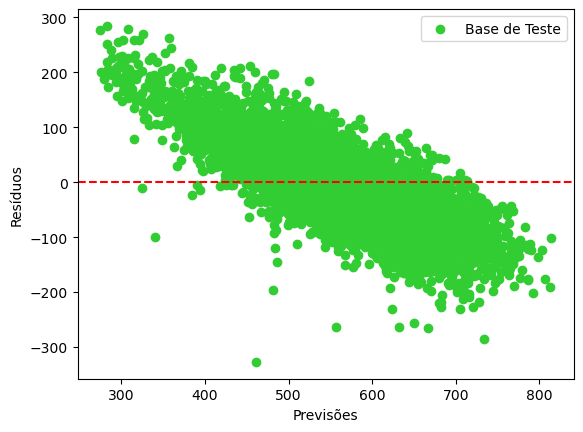

In [27]:
# Supondo que y_pred e y_test já estão definidos
plt.scatter(previsao_modelo_2['MEDIA_RESULTADO'], previsao_modelo_2['y_previsto'] - previsao_modelo_2['MEDIA_RESULTADO'], c='limegreen', label='Base de Teste')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.legend()
plt.show()

#df_predictions_teste = pd.DataFrame(predictions_teste, columns=['y_previsto'])

In [ ]:
# Teste modelo fora da amostra de treino e teste

In [ ]:
# Verificando o resultado
#print(AMOSTRA_TESTE_DF.head())

from sklearn.model_selection import train_test_split

# Dividindo a amostra com estratificação
AMOSTRA_TESTE_DF, _ = train_test_split(PARTIC_ENEM_2023_DF, test_size=0.90, stratify=PARTIC_ENEM_2023_DF[['TP_ESCOLA']], random_state = 42)

AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF[['TP_SEXO', 'TP_ESCOLA', 'TP_NACIONALIDADE', 'TP_COR_RACA', 'TP_ESTADO_CIVIL', 'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA',
                                     'TP_LOCALIZACAO_ESC', 'CO_MUNICIPIO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001',
                                     'Q002','Q003','Q004','Q005','Q006','Q007', 'Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018',
                                     'Q019','Q020','Q021','Q022','Q023','Q024','Q025']]
# Calcular média das notas e status
AMOSTRA_TESTE_DF['MEDIA_RESULTADO'] = (
    (AMOSTRA_TESTE_DF['NU_NOTA_CN'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_CH'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_LC'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_MT'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_REDACAO']) / 5
)
AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF.drop(columns=drop_columns)

AMOSTRA_TESTE_DF = pd.get_dummies(AMOSTRA_TESTE_DF, columns=categorical_columns, prefix=categorical_columns)
# Definir X e y
AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF.drop(columns=['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])

colunas_faltantes_em_X_train = set(AMOSTRA_TESTE_DF.columns) - set(X_train.columns)
colunas_faltantes_em_AMOSTRA_TESTE_DF = set(X_train.columns) - set(AMOSTRA_TESTE_DF.columns)

AMOSTRA_TESTE_DF.columns

# Adicionar colunas faltantes com valores zero
for coluna in colunas_faltantes_em_AMOSTRA_TESTE_DF:
    AMOSTRA_TESTE_DF[coluna] = 0

# Verificar se as colunas estão na mesma ordem de X_train.columns
#AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF[X_train.columns]

# Verificando o resultado
print(colunas_faltantes_em_X_train)
print(colunas_faltantes_em_AMOSTRA_TESTE_DF)

In [ ]:
# Criar colunas faltantes com valor zerado
AMOSTRA_TESTE_DF['Q005_16'] = False
AMOSTRA_TESTE_DF['Q005_13'] = False
AMOSTRA_TESTE_DF['Q005_14'] = False
AMOSTRA_TESTE_DF['Q005_19'] = False
#AMOSTRA_TESTE_DF['Q008_A'] = False
#AMOSTRA_TESTE_DF.columns

In [ ]:
#AMOSTRA_TESTE_DF.columns
X_BKT = AMOSTRA_TESTE_DF
y_BKT = AMOSTRA_TESTE_DF['MEDIA_RESULTADO']

X_BKT = AMOSTRA_TESTE_DF[X_train.columns]

colunas_faltantes_em_X_train = set(X_BKT.columns) - set(X_train.columns)
colunas_faltantes_em_X_BKT = set(X_train.columns) - set(X_BKT.columns)

# Verificando o resultado
print(colunas_faltantes_em_X_train)
print(colunas_faltantes_em_X_BKT)

In [ ]:
sc = StandardScaler()
X_BKT_scaled = sc.fit_transform(X_BKT)
predictions_teste_BKT = modelo_2.predict(X_BKT_scaled)

In [ ]:
predictions_teste_BKT = pd.DataFrame(predictions_teste_BKT.flatten(), columns=['y_previsto_BKT'])
predictions_teste_BKT.hist()
predictions_teste_BKT.columns
#y_test.hist()

In [ ]:
print("A média Máxima da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].max())
print("A média Mínima da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].min())
print("A média da média da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].mean())
print("A médiana da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].median())
print("A média Máxima do y_test real é de: ", y_BKT.max())
print("A média Mínima do y_test real é de: ", y_BKT.min())
print("A média da média do y_test real é de: ", y_BKT.mean())
print("A médiana da média do y_test real é de: ", y_BKT.median())

In [ ]:
#df_y_test = pd.DataFrame(y_test)
#previsao_modelo_2 = pd.DataFrame({'y_previsto': predictions_teste['y_previsto'], 'MEDIA_RESULTADO': df_y_test['MEDIA_RESULTADO']})

df_y_BKT = pd.DataFrame(y_BKT, columns=['MEDIA_RESULTADO'])
df_y_BKT.reset_index(drop=True, inplace=True)

df_predictions_teste = pd.DataFrame(predictions_teste_BKT, columns=['y_previsto_BKT'])

previsao_modelo_2_BKT = pd.concat([predictions_teste_BKT, df_y_BKT],join='outer', axis=1)

previsao_modelo_2_BKT.reset_index(drop=True, inplace=True)

previsao_modelo_2_BKT['ERRO'] = np.abs(previsao_modelo_2_BKT['y_previsto_BKT'] - previsao_modelo_2_BKT['MEDIA_RESULTADO'])
previsao_modelo_2_BKT['ERRO_REL'] = np.abs(previsao_modelo_2_BKT['ERRO'] / previsao_modelo_2_BKT['MEDIA_RESULTADO'])
previsao_modelo_2_BKT.sort_values(by='ERRO_REL', ascending=True).head(15)

In [ ]:
MAE_MODELO_2_BKT = sum(previsao_modelo_2_BKT['ERRO'])/len(previsao_modelo_2_BKT['ERRO'])
MAPE_MODELO_2_BKT = np.mean(previsao_modelo_2_BKT['ERRO_REL'])

print(MAE_MODELO_2_BKT)
print(MAPE_MODELO_2_BKT)

In [ ]:
# Definir os intervalos de erro
bins = [0, 0.1, 0.3, 0.5, 0.7, float('inf')]
labels = ['Erro entre 0% e 10%', 'Erro entre 10% e 30%', 'Erro entre 30% e 50%', 'Erro entre 50% e 70%', 'Acima de 70%']

# Categorizar os dados
previsao_modelo_2_BKT['Intervalo_ERRO_REL'] = pd.cut(previsao_modelo_2_BKT['ERRO_REL'], bins=bins, labels=labels)

# Construir a tabela de distribuição de frequência
frequencia_BKT = previsao_modelo_2_BKT['Intervalo_ERRO_REL'].value_counts().sort_index()

# Exibir a tabela de distribuição de frequência
tabela_frequencia_BKT = pd.DataFrame({'Intervalo de Erro Relativo': labels, 'Frequência_BKT': frequencia_BKT})
tabela_frequencia_BKT['FREQ_REL'] = tabela_frequencia_BKT['Frequência_BKT']/sum(tabela_frequencia_BKT['Frequência_BKT'])
tabela_frequencia_BKT

In [ ]:
# Supondo que y_pred e y_test já estão definidos
plt.scatter(previsao_modelo_2_BKT['MEDIA_RESULTADO'], previsao_modelo_2_BKT['MEDIA_RESULTADO'] - previsao_modelo_2_BKT['y_previsto_BKT'], 
            c='limegreen', label='Base de Teste')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.legend()
plt.show()